In [1]:
import numpy as np
import torch

In [2]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 10
num_samples = 1000

In [3]:
#define some useful functions
def generate_HMM_params(num_hidden_state, num_obs):
    # random generate the transition matrix and observation matrix, and compute the stationary distribution
    
    alpha_state = np.ones(num_hidden_state)
    alpha_obs = np.ones(num_obs) / num_obs
    trans_mat = np.random.dirichlet(alpha_state, num_hidden_state)
    obs_mat = np.random.dirichlet(alpha_obs, num_hidden_state)
    tmp = np.ones((num_hidden_state + 1, num_hidden_state))
    tmp[:-1] = np.identity(num_hidden_state) - trans_mat.T
    tmp_v = np.zeros(num_hidden_state + 1)
    tmp_v[-1] = 1
    stat_dist = np.linalg.lstsq(tmp, tmp_v, rcond=None)[0]
    return trans_mat, obs_mat, stat_dist

In [4]:
def generate_HMM_sequences(trans_mat, obs_mat, init_dist, length, num_samples = 1):
    # generate sample sequences from HMM
    
    states = np.zeros((num_samples, length))
    obs = np.zeros((num_samples, length))
    tmp_state = np.argmax(np.random.multinomial(1, init_dist, num_samples), axis = 1)
    #print(tmp_state)
    for i in range(length):
        #print("i: ", i)
        states[:, i] = tmp_state
        for j in range(num_samples):
            obs[j, i] = np.random.multinomial(1, obs_mat[tmp_state[j]]).argmax()
            tmp_state[j] = np.random.multinomial(1, trans_mat[tmp_state[j]]).argmax()
        #print("obs[:, i]: ", obs[:, i])
    return states, obs

In [5]:
def forward_compute(trans_mat, obs_mat, init_dist, obs_to_pos):
    # compute \sum_{h_1,...,h_{pos-1}} P(h_1,...,h_{pos},x_1,...,x_{pos-1})
    pos = obs_to_pos.shape[0] + 1
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    forward = np.zeros((pos, num_hidden_state))
    forward[0] = init_dist
    for i in range(1, pos):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                #print(i, j, k)
                #print(forward[i - 1, k], trans_mat[k, j], obs_mat[k, int(obs_to_pos[i - 1])])
                forward[i, j] += forward[i - 1, k] * trans_mat[k, j] * obs_mat[k, int(obs_to_pos[i - 1])]
    #print("forward: ", forward)
    return forward[pos - 1]

In [6]:
def backward_compute(trans_mat, obs_mat, obs_from_pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    back_length = obs_from_pos.shape[0]
    if (back_length == 0):
        return np.ones(num_hidden_state)
    backward = np.zeros((back_length, num_hidden_state))
    for j in range(num_hidden_state):
         for k in range(num_hidden_state):
            backward[0, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-1])]
    for i in range(1, back_length):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                backward[i, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-(i + 1)])] * backward[i - 1, k]
    #print("backward: ", backward)
    return backward[-1]

In [7]:
def x_i_conditional_prob(trans_mat, obs_mat, init_dist, known_X, pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    num_samples = known_X.shape[0]
    length = known_X.shape[1]
    x_pos_conditional_prob = np.zeros((num_samples, num_obs))
    h_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    h_all_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    for i in range(num_samples):
        #print("x_i_conditional_prob: i=", i)
        sample_obs_vec = known_X[i]
        forward_vec = forward_compute(trans_mat, obs_mat, init_dist, known_X[i, :pos[i]])
        backward_vec = backward_compute(trans_mat, obs_mat, known_X[i, pos[i] + 1:])
        #print("forward_vec: ", forward_vec)
        #print("backward_vec: ", backward_vec)
        h_prob_tmp = forward_vec * backward_vec
        tmp = h_prob_tmp.sum()
        h_prob_tmp /= tmp
        h_pos_conditional_prob[i] = h_prob_tmp
        x_pos_conditional_prob[i] = h_prob_tmp @ obs_mat
        h_all_pos_conditional_prob[i] = h_prob_tmp * obs_mat[:, int(known_X[i, pos[i]])] / x_pos_conditional_prob[i, int(known_X[i, pos[i]])]
    return h_pos_conditional_prob, x_pos_conditional_prob, h_all_pos_conditional_prob

In [8]:
seed = 20211018
np.random.seed(seed)
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5: ")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5: 
[[1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [0. 2. 0. 2. 0. 2. 2. 2. 1. 0. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 2. 2. 0. 1. 0. 2. 1. 2. 0. 1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [1. 0. 1. 0. 2. 1. 1. 1. 0. 1. 4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]]
positions, only showing first 5:  [9 4 6 2 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.21892801 0.54738046 0.

In [9]:
logh = np.log(h)

In [10]:
from torch import nn
from torch.utils import data

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linearnetwork = nn.Sequential(
            nn.Linear(num_obs, num_hidden_state, bias=False)
        )
    
    def forward(self, logh, ind_x):
        logits = self.linearnetwork(ind_x)
        return nn.Softmax(dim = 1)(logh + logits)

In [12]:
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
#print(pos[:9])
#print(obs[:9])
#print(x_one_hot[:9])

[9 4 6 2 1 3 1 2 1]
[[0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]
 [1. 0. 1. 0. 0. 3. 1. 0. 3. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 3.]
 [4. 3. 0. 1. 1. 1. 0. 3. 1. 3.]
 [3. 1. 0. 2. 4. 3. 1. 3. 1. 1.]]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [13]:
features1, features2, labels = logh, x_one_hot, hh

In [14]:
# Model parameters.
lr = 1
epochs = 1000
batch_size = 100

In [15]:
dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
train_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
net = NeuralNetwork()

In [17]:
loss = nn.KLDivLoss(reduction='batchmean')

In [18]:
def shiftedNegLLLoss(outputs, targets):
    batchsize = outputs.size()[0]
    log_outputs = torch.log(outputs)
    tmp_loss = - targets * log_outputs
    tmp = - targets * torch.log(targets)
    return torch.sum(tmp_loss - tmp) / num_samples

In [19]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [20]:
total_loss_lst = []
for i in range(epochs):
    total_loss = 0
    for X1, X2, y in train_dl:
        l = loss(torch.log(net(X1, X2)), y)
        #l = shiftedNegLLLoss(net(X1, X2), y)
        total_loss += l
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if (i % 100 == 0):
        print("epoch: ", i)
        print("loss: ", total_loss)
        total_loss_lst.append(total_loss)

epoch:  0
loss:  tensor(1.7009, grad_fn=<AddBackward0>)
epoch:  100
loss:  tensor(0.0122, grad_fn=<AddBackward0>)
epoch:  200
loss:  tensor(0.0064, grad_fn=<AddBackward0>)
epoch:  300
loss:  tensor(0.0043, grad_fn=<AddBackward0>)
epoch:  400
loss:  tensor(0.0033, grad_fn=<AddBackward0>)
epoch:  500
loss:  tensor(0.0026, grad_fn=<AddBackward0>)
epoch:  600
loss:  tensor(0.0022, grad_fn=<AddBackward0>)
epoch:  700
loss:  tensor(0.0019, grad_fn=<AddBackward0>)
epoch:  800
loss:  tensor(0.0017, grad_fn=<AddBackward0>)
epoch:  900
loss:  tensor(0.0015, grad_fn=<AddBackward0>)


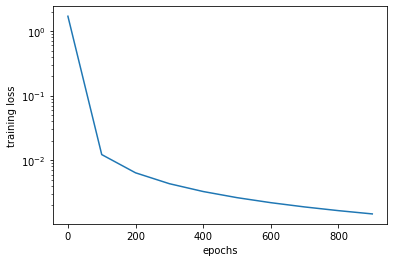

In [21]:
import matplotlib.pyplot as plt
x_lst = list(range(0, 1000, 100))
plt.plot(x_lst, total_loss_lst)
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

In [22]:
print("learned matrix:")
print(net.linearnetwork[0].weight.data.numpy())
print("log(O):")
print(np.log(obs_mat))
print("Difference:")
print(net.linearnetwork[0].weight.data.numpy() - np.log(obs_mat))

learned matrix:
[[ 1.3045962  -0.62654877 -0.42787576  3.3971775   0.25236118]
 [ 0.6710247   0.33821243 -0.20606275  0.38431484  2.7212012 ]
 [-2.1470218   0.69743556  0.8168571  -3.3849497  -2.8997552 ]]
log(O):
[[ -1.25729566  -1.38032328  -4.32893177  -0.82547526  -4.35268422]
 [ -1.89086747  -0.41556183  -4.10711787  -3.83531198  -1.89021013]
 [ -4.70896735  -0.05633851  -3.08419628 -23.26446841 -21.49641299]]
Difference:
[[ 2.56189185  0.75377451  3.90105601  4.22265271  4.6050454 ]
 [ 2.56189215  0.75377426  3.90105512  4.21962682  4.61141132]
 [ 2.56194558  0.75377407  3.90105338 19.87951873 18.59665775]]


In [23]:
net.eval()

NeuralNetwork(
  (linearnetwork): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=False)
  )
)

In [24]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[0. 1. 0. 0. 2. 1. 0. 2. 0. 2. 0. 0. 0. 0. 1. 0. 3. 1. 1. 1.]
 [0. 2. 0. 1. 1. 0. 2. 1. 0. 1. 3. 1. 3. 4. 1. 3. 1. 4. 0. 1.]
 [1. 0. 1. 0. 2. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]
 [2. 0. 0. 1. 0. 1. 0. 2. 2. 1. 1. 1. 1. 1. 1. 4. 3. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1. 1. 0. 1. 1. 1.]]
positions, only showing first 5:  [2 2 5 8 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.2431274  0.58828537 

In [25]:
logh = np.log(h)
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
print(pos[:9])
print(obs[:9])
print(x_one_hot[:9])

[2 2 5 8 1 9 4 2 4]
[[0. 0. 0. 0. 1. 0. 3. 1. 1. 1.]
 [3. 1. 3. 4. 1. 3. 1. 4. 0. 1.]
 [1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 4. 3. 1. 1. 0.]
 [3. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 3. 0.]
 [1. 3. 1. 3. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 3. 1. 3. 1. 3. 4.]
 [1. 1. 0. 1. 1. 3. 0. 1. 3. 1.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [26]:
features1, features2, labels = logh, x_one_hot, hh

In [27]:
test_dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=False)

In [29]:
for X1, X2, Y in test_dl:
    print(loss(torch.log(net(X1, X2)), Y))
    print(np.linalg.norm(net(X1, X2).detach().numpy() - Y.numpy()) ** 2 / num_samples)
    print(X1[2])
    print(np.log(np.array([0.345, 0.536, 0.119])))
    print(X2[2])
    print(Y[2])
    print(net(X1, X2)[:5])
    tmp = X2[2].numpy().T @ np.log(obs_mat.T) + X1[2].numpy()
    print(np.exp(tmp) / np.sum(np.exp(tmp)))
    print(Y[:5])
    break

tensor(0.0001, grad_fn=<DivBackward0>)
1.9857181814941782e-07
tensor([-1.0633, -0.6241, -2.1292])
[-1.06421086 -0.62362112 -2.12863179]
tensor([1., 0., 0., 0., 0.])
tensor([0.5452, 0.4489, 0.0060])
tensor([[4.3364e-01, 5.5683e-01, 9.5301e-03],
        [9.7283e-01, 2.7046e-02, 1.2313e-04],
        [5.4515e-01, 4.4889e-01, 5.9511e-03],
        [2.0811e-01, 6.1825e-01, 1.7364e-01],
        [1.0873e-01, 5.2626e-01, 3.6501e-01]], grad_fn=<SliceBackward>)
[0.54515431 0.4488949  0.00595079]
tensor([[4.3364e-01, 5.5683e-01, 9.5296e-03],
        [9.7287e-01, 2.7129e-02, 1.9529e-11],
        [5.4515e-01, 4.4889e-01, 5.9508e-03],
        [2.0811e-01, 6.1825e-01, 1.7364e-01],
        [1.0873e-01, 5.2626e-01, 3.6501e-01]])


In [108]:
#net.linearnetwork[0].weight.data = torch.from_numpy(np.log(obs_mat)).float()

In [129]:
net.linearnetwork[0].weight.data

tensor([[ -1.2573,  -1.3803,  -4.3289,  -0.8255,  -4.3527],
        [ -1.8909,  -0.4156,  -4.1071,  -3.8353,  -1.8902],
        [ -4.7090,  -0.0563,  -3.0842, -23.2645, -21.4964]])

In [130]:
for X1, X2, y in train_dl:
    print(X1[0])
    print(X2[0])
    print(net(X1, X2)[0])
    print(y[0])
    print(net.linearnetwork[0].weight.data.numpy())
    print(X2[2].numpy().T @ np.log(obs_mat.T) + X1[0].numpy())
    print(X2[2].numpy().T @ net.linearnetwork[0].weight.data.numpy().T + X1[0].numpy())
    print(X2[2].numpy().T @ (np.log(obs_mat.T) - net.linearnetwork[0].weight.data.numpy().T))
    print(np.log(obs_mat))
    break

tensor([-1.5190, -0.6026, -1.4538])
tensor([0., 1., 0., 0., 0.])
tensor([0.0864, 0.5669, 0.3467], grad_fn=<SelectBackward>)
tensor([0.0864, 0.5669, 0.3467])
[[ -1.2572956   -1.3803233   -4.328932    -0.8254753   -4.352684  ]
 [ -1.8908675   -0.41556183  -4.1071177   -3.835312    -1.8902102 ]
 [ -4.708967    -0.05633851  -3.0841963  -23.26447    -21.496412  ]]
[-2.89933561 -1.01817301 -1.51009174]
[-2.8993356 -1.018173  -1.5100918]
[ 1.02977817e-08 -5.67847230e-09  1.08131138e-09]
[[ -1.25729566  -1.38032328  -4.32893177  -0.82547526  -4.35268422]
 [ -1.89086747  -0.41556183  -4.10711787  -3.83531198  -1.89021013]
 [ -4.70896735  -0.05633851  -3.08419628 -23.26446841 -21.49641299]]


In [46]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states")
print(np.concatenate((states, obs), axis = 1))
print("positions: ", pos)
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(h)
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(x)
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j]:")
print(hh)

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states
[[1. 0. 1. ... 2. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 0. ... 1. 1. 0.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 0. 1.]]
positions:  [8 3 0 2 1 5 1 6 6 2 2 6 5 5 1 4 7 7 8 6 0 8 5 9 0 2 8 7 1 9 7 9 1 8 2 4 1
 1 4 7 6 2 7 3 9 2 7 6 2 5 8 7 8 9 0 1 8 0 0 9 5 4 7 6 7 3 4 9 5 8 3 7 8 3
 9 9 0 4 2 6 6 9 1 9 1 5 5 8 1 4 0 3 1 4 7 1 0 6 9 2 2 2 7 4 8 2 7 2 2 6 1
 4 7 6 8 0 1 4 2 1 8 7 3 1 7 8 3 1 7 6 3 5 1 9 1 5 8 3 1 7 7 0 8 6 7 4 3 1
 8 4 8 8 7 8 1 9 2 1 9 1 7 5

In [131]:
logh = np.log(h)
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
features1, features2, labels = logh, x_one_hot, hh

In [132]:
test_dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
test_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [133]:
for X1, X2, y in test_dl:
    print(net(X1, X2)[:9])
    print(y[:9])
    break

tensor([[8.6408e-02, 5.6694e-01, 3.4665e-01],
        [5.9854e-02, 9.4015e-01, 1.3646e-09],
        [3.4539e-01, 4.7921e-01, 1.7540e-01],
        [1.0109e-01, 6.7997e-01, 2.1894e-01],
        [3.8309e-01, 5.3579e-01, 8.1121e-02],
        [6.9207e-01, 3.0419e-01, 3.7369e-03],
        [6.4259e-01, 3.4938e-01, 8.0260e-03],
        [4.9077e-01, 4.9475e-01, 1.4478e-02],
        [5.1444e-02, 6.0975e-01, 3.3881e-01]], grad_fn=<SliceBackward>)
tensor([[8.6408e-02, 5.6694e-01, 3.4665e-01],
        [5.9853e-02, 9.4015e-01, 1.3646e-09],
        [3.4539e-01, 4.7921e-01, 1.7540e-01],
        [1.0109e-01, 6.7997e-01, 2.1894e-01],
        [3.8309e-01, 5.3579e-01, 8.1121e-02],
        [6.9207e-01, 3.0419e-01, 3.7369e-03],
        [6.4259e-01, 3.4938e-01, 8.0260e-03],
        [4.9077e-01, 4.9475e-01, 1.4478e-02],
        [5.1444e-02, 6.0975e-01, 3.3881e-01]])
